# Flujo Óptico de Lucas-Kanade

**Objetivo:** Entender e implementar el método de Lucas-Kanade desde los fundamentos matemáticos hasta la práctica.

## Recordatorio de los Tres Supuestos

1. **Constancia de brillo:** $I(x,y,t) = I(x+u, y+v, t+1)$
2. **Movimiento coherente:** Todos los píxeles en una ventana pequeña tienen el mismo $(u,v)$
3. **Movimiento pequeño:** $|u|, |v| < 1-2$ píxeles (para validez de Taylor)

## La Ecuación Fundamental

Para cada píxel en la ventana:
$$I_x \cdot u + I_y \cdot v = -I_t$$

Sistema matricial:
$$A\mathbf{v} = \mathbf{b} \quad \text{donde} \quad \mathbf{v} = (A^T A)^{-1} A^T \mathbf{b}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2

# Para visualización
plt.rcParams['figure.figsize'] = (12, 4)
np.set_printoptions(precision=3, suppress=True)

---
## Paso 1: Generar Ejemplo Sintético

Crear dos frames con un cuadrado blanco que se mueve 3 píxeles hacia la derecha.


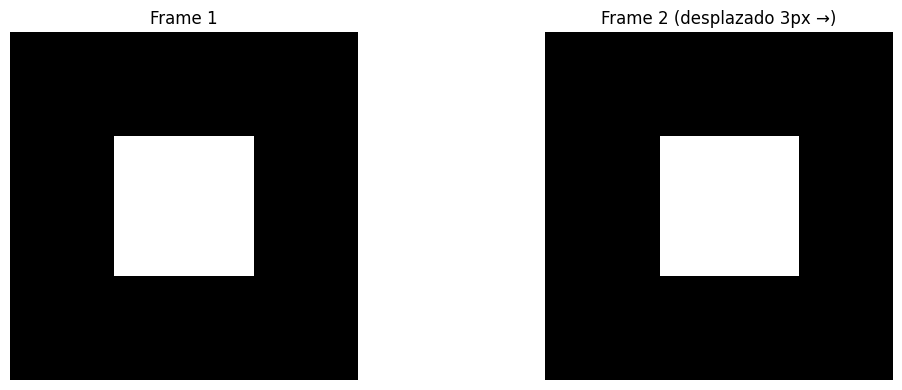

Dimensiones: (100, 100)
Flujo verdadero esperado: u=3, v=0


In [2]:
def crear_frames_sinteticos(desplazamiento=3):
    """
    Crea dos frames con un cuadrado blanco que se desplaza horizontalmente.
    
    Args:
        desplazamiento: Píxeles que se mueve el cuadrado hacia la derecha
    
    Returns:
        frame1, frame2: Dos frames consecutivos (100x100)
    """
    # Crear frames negros
    frame1 = np.zeros((100, 100), dtype=np.float32)
    frame2 = np.zeros((100, 100), dtype=np.float32)
    
    # Posición inicial del cuadrado (centro)
    x_inicial = 30
    y_inicial = 30
    tamaño = 40
    
    # Dibujar cuadrado en frame 1
    frame1[y_inicial:y_inicial+tamaño, x_inicial:x_inicial+tamaño] = 255.0
    
    # Dibujar cuadrado desplazado en frame 2
    x_final = x_inicial + desplazamiento
    frame2[y_inicial:y_inicial+tamaño, x_final:x_final+tamaño] = 255.0
    
    return frame1, frame2

# Generar frames
frame1, frame2 = crear_frames_sinteticos(desplazamiento=3)

# Visualizar
fig, axes = plt.subplots(1, 2)
axes[0].imshow(frame1, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Frame 1')
axes[0].axis('off')

axes[1].imshow(frame2, cmap='gray', vmin=0, vmax=255)
axes[1].set_title('Frame 2 (desplazado 3px →)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Dimensiones: {frame1.shape}")
print(f"Flujo verdadero esperado: u=3, v=0")

---
## Paso 2: Calcular Gradientes Espaciales ($I_x$, $I_y$)

**tres métodos** para calcular derivadas y comparar:

1. **Diferencias centradas** (simple)
2. **Sobel** (robusto al ruido)
3. **OpenCV** (optimizado)

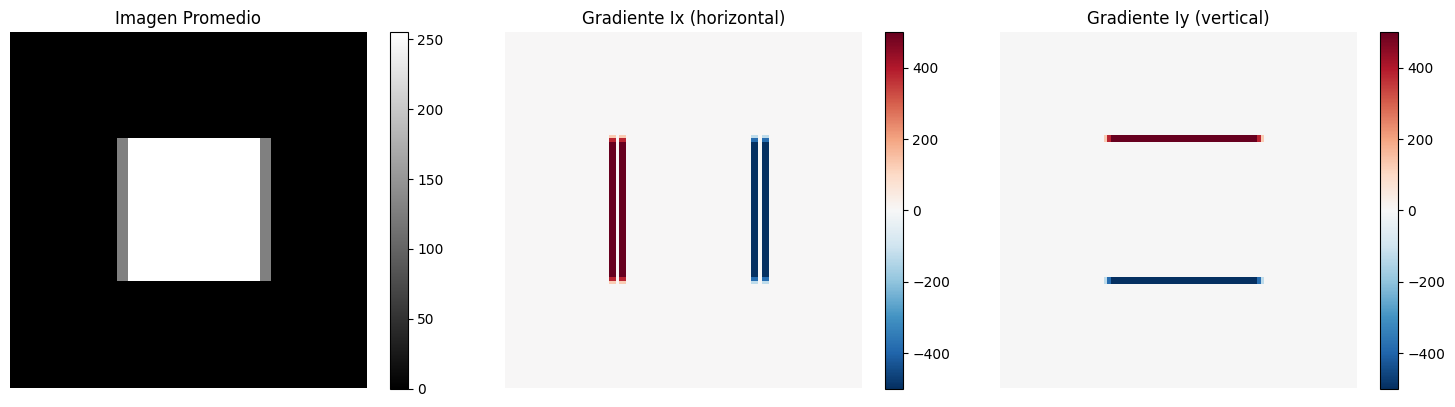

In [3]:
def calcular_gradiente_diferencias_centradas(img):
    """
    Calcula gradientes usando diferencias centradas.
    Kernel: [-0.5, 0, 0.5]
    """
    # Gradiente en x: derivada horizontal
    Ix = np.zeros_like(img)
    Ix[:, 1:-1] = (img[:, 2:] - img[:, :-2]) / 2.0
    
    # Gradiente en y: derivada vertical
    Iy = np.zeros_like(img)
    Iy[1:-1, :] = (img[2:, :] - img[:-2, :]) / 2.0
    
    return Ix, Iy

def calcular_gradiente_sobel(img):
    """
    Calcula gradientes usando operador de Sobel.
    Combina derivada con suavizado.
    """
    # Kernels de Sobel
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)
    
    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]], dtype=np.float32)
    
    # Convolución (usando correlación de OpenCV para simplicidad)
    Ix = cv2.filter2D(img, -1, sobel_x)
    Iy = cv2.filter2D(img, -1, sobel_y)
    
    return Ix, Iy

# Calcular con ambos métodos (usaremos promedio de frames para gradientes espaciales)
img_promedio = (frame1 + frame2) / 2.0

Ix_diff, Iy_diff = calcular_gradiente_diferencias_centradas(img_promedio)
Ix_sobel, Iy_sobel = calcular_gradiente_sobel(img_promedio)

# Usaremos Sobel para el resto del tutorial (más robusto)
Ix = Ix_sobel
Iy = Iy_sobel

# Visualizar gradientes
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

im0 = axes[0].imshow(img_promedio, cmap='gray')
axes[0].set_title('Imagen Promedio')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(Ix, cmap='RdBu_r', vmin=-500, vmax=500)
axes[1].set_title('Gradiente Ix (horizontal)')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(Iy, cmap='RdBu_r', vmin=-500, vmax=500)
axes[2].set_title('Gradiente Iy (vertical)')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()


---
## Paso 3: Calcular Gradiente Temporal ($I_t$)

Este es el más simple: diferencia entre frames consecutivos.

$$I_t = I_2 - I_1$$

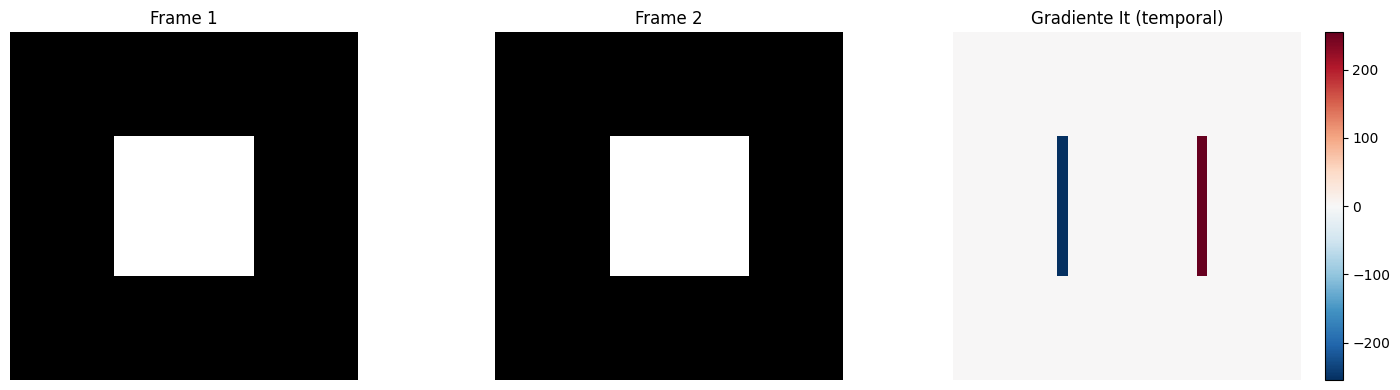


Interpretación:
- Azul (negativo): Píxeles que 'desaparecieron' (borde izquierdo del cuadrado)
- Rojo (positivo): Píxeles que 'aparecieron' (borde derecho del cuadrado)
- Gris (cero): Píxeles sin cambio


In [4]:
# Derivada temporal
It = frame2 - frame1

# Visualizar
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow(frame1, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Frame 1')
axes[0].axis('off')

axes[1].imshow(frame2, cmap='gray', vmin=0, vmax=255)
axes[1].set_title('Frame 2')
axes[1].axis('off')

im = axes[2].imshow(It, cmap='RdBu_r', vmin=-255, vmax=255)
axes[2].set_title('Gradiente It (temporal)')
axes[2].axis('off')
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

print("\nInterpretación:")
print("- Azul (negativo): Píxeles que 'desaparecieron' (borde izquierdo del cuadrado)")
print("- Rojo (positivo): Píxeles que 'aparecieron' (borde derecho del cuadrado)")
print("- Gris (cero): Píxeles sin cambio")

---
## Paso 4: Implementar Lucas-Kanade - La Función Core

Ahora viene lo importante: aplicar la solución de mínimos cuadrados.

Para cada ventana de tamaño $w \times w$:

$$\mathbf{v} = (A^T A)^{-1} A^T \mathbf{b}$$

Donde:
- $A$ es la matriz de gradientes espaciales (n×2)
- $\mathbf{b}$ es el vector de gradientes temporales (n×1)
- $\mathbf{v} = [u, v]^T$ es el flujo óptico


In [5]:
def lucas_kanade_ventana(Ix, Iy, It, x, y, tamaño_ventana=5):
    """
    Calcula el flujo óptico (u, v) para una ventana centrada en (x, y).
    
    Args:
        Ix, Iy, It: Gradientes de la imagen
        x, y: Centro de la ventana
        tamaño_ventana: Tamaño de la ventana (impar)
    
    Returns:
        u, v: Componentes del flujo óptico
    """
    medio = tamaño_ventana // 2
    
    # Extraer ventana
    y_min, y_max = y - medio, y + medio + 1
    x_min, x_max = x - medio, x + medio + 1
    
    # Verificar límites
    if y_min < 0 or y_max > Ix.shape[0] or x_min < 0 or x_max > Ix.shape[1]:
        return 0.0, 0.0
    
    # Extraer gradientes en la ventana
    Ix_ventana = Ix[y_min:y_max, x_min:x_max].flatten()
    Iy_ventana = Iy[y_min:y_max, x_min:x_max].flatten()
    It_ventana = It[y_min:y_max, x_min:x_max].flatten()
    
    # Construir matriz A (n × 2)
    A = np.vstack([Ix_ventana, Iy_ventana]).T  # shape: (n, 2)
    
    # Construir vector b (n × 1)
    b = -It_ventana.reshape(-1, 1)  # shape: (n, 1)
    
    # Resolver sistema de mínimos cuadrados: v = (A^T A)^{-1} A^T b
    ATA = A.T @ A  # (2 × 2)
    ATb = A.T @ b  # (2 × 1)
    
    # Verificar que la matriz sea invertible
    # Calculamos el determinante de A^T A
    det = np.linalg.det(ATA)
    
    if abs(det) < 1e-7:
        # Matriz singular (región uniforme sin textura)
        return 0.0, 0.0
    
    # Invertir y resolver
    ATA_inv = np.linalg.inv(ATA)
    v = ATA_inv @ ATb
    
    u, v_y = v[0, 0], v[1, 0]
    
    return u, v_y

# Probar en un punto dentro del cuadrado
x_test, y_test = 50, 50  # Centro del cuadrado
u, v = lucas_kanade_ventana(Ix, Iy, It, x_test, y_test, tamaño_ventana=7)

print(f"\nFlujo óptico en el punto ({x_test}, {y_test}):")
print(f"  u (horizontal) = {u:.3f}")
print(f"  v (vertical)   = {v:.3f}")



Flujo óptico en el punto (50, 50):
  u (horizontal) = 0.000
  v (vertical)   = 0.000


---
## Paso 5: Calcular Flujo para Múltiples Puntos

Aplicar Lucas-Kanade en una grilla de puntos para visualizar el campo de flujo completo.

Se espera que el algoritmo funcione bien en:
1. El centro del cuadrado (región uniforme blanca)?
2. Los bordes del cuadrado (transición blanco-negro)?
3. El fondo negro (región uniforme)?

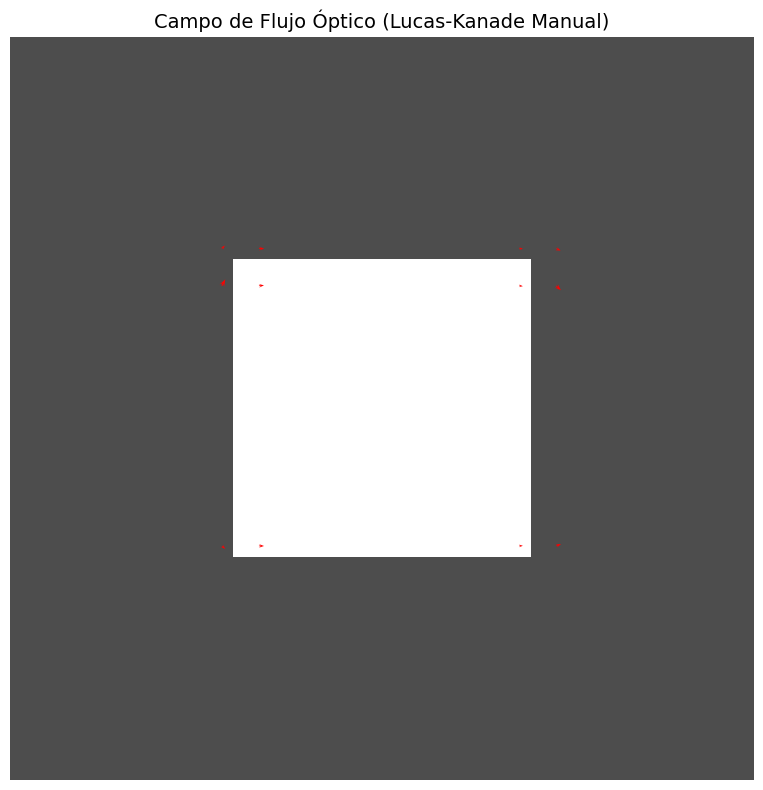


Estadísticas del flujo calculado:
  Número de puntos: 12
  u promedio: 0.285 (esperado: 3.0)
  u desviación estándar: 0.048
  v promedio: 0.011 (esperado: 0.0)
  v desviación estándar: 0.180


In [13]:
def calcular_flujo_grilla(Ix, Iy, It, paso=10, tamaño_ventana=7):
    """
    Calcula flujo óptico en una grilla de puntos.
    
    Args:
        Ix, Iy, It: Gradientes
        paso: Espaciado entre puntos de la grilla
        tamaño_ventana: Tamaño de ventana para Lucas-Kanade
    
    Returns:
        x_coords, y_coords: Coordenadas de los puntos
        u_vals, v_vals: Componentes del flujo
    """
    altura, ancho = Ix.shape
    
    x_coords = []
    y_coords = []
    u_vals = []
    v_vals = []
    
    medio = tamaño_ventana // 2
    
    for y in range(medio, altura - medio, paso):
        for x in range(medio, ancho - medio, paso):
            u, v = lucas_kanade_ventana(Ix, Iy, It, x, y, tamaño_ventana)
            
            # Solo guardar si el flujo es significativo
            if abs(u) > 0.1 or abs(v) > 0.1:
                x_coords.append(x)
                y_coords.append(y)
                u_vals.append(u)
                v_vals.append(v)
    
    return np.array(x_coords), np.array(y_coords), np.array(u_vals), np.array(v_vals)

# Calcular flujo en grilla
x_pts, y_pts, u_flow, v_flow = calcular_flujo_grilla(Ix, Iy, It, paso=5, tamaño_ventana=7)

# Visualizar
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(frame1, cmap='gray', alpha=0.7)
ax.quiver(x_pts, y_pts, u_flow, v_flow, 
          color='red', scale=50, width=0.003, 
          headwidth=5, headlength=7)
ax.set_title('Campo de Flujo Óptico (Lucas-Kanade Manual)', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

# Estadísticas
print(f"\nEstadísticas del flujo calculado:")
print(f"  Número de puntos: {len(u_flow)}")
print(f"  u promedio: {np.mean(u_flow):.3f} (esperado: 3.0)")
print(f"  u desviación estándar: {np.std(u_flow):.3f}")
print(f"  v promedio: {np.mean(v_flow):.3f} (esperado: 0.0)")
print(f"  v desviación estándar: {np.std(v_flow):.3f}")

---
## Paso 6: Comparación con OpenCV

implementación optimizada de OpenCV para validar nuestros resultados.

`cv2.calcOpticalFlowPyrLK()` implementa Lucas-Kanade con pirámides (para manejar movimientos grandes).


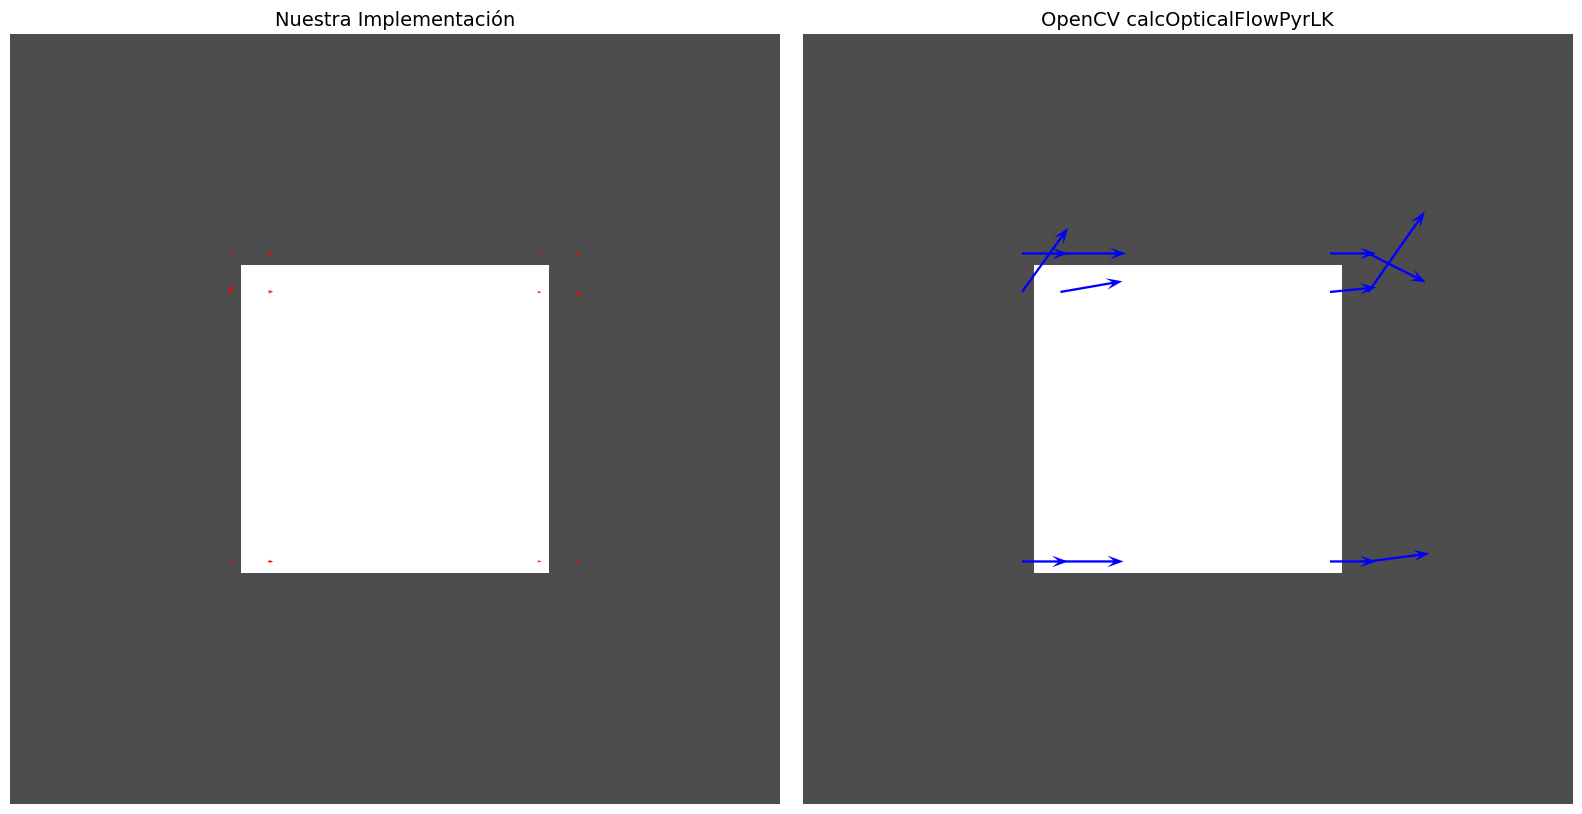


=== COMPARACIÓN ===

Nuestra implementación:
  u promedio: 0.285 ± 0.048
  v promedio: 0.011 ± 0.180

OpenCV:
  u promedio: 3.482 ± 0.503
  v promedio: 0.750 ± 1.876

Valor real:
  u = 3.0, v = 0.0

Diferencia promedio entre implementaciones:
  Error en u: 3.197
  Error en v: 1.068


In [14]:
# Convertir a uint8 para OpenCV
frame1_uint8 = frame1.astype(np.uint8)
frame2_uint8 = frame2.astype(np.uint8)

# Definir puntos donde calcular el flujo (misma grilla que antes)
puntos_iniciales = np.array([[x, y] for x, y in zip(x_pts, y_pts)], dtype=np.float32)
puntos_iniciales = puntos_iniciales.reshape(-1, 1, 2)

# Parámetros de Lucas-Kanade
lk_params = dict(
    winSize=(7, 7),  # Mismo tamaño de ventana
    maxLevel=0,      # Sin pirámides (para comparación justa)
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
)

# Calcular flujo con OpenCV
puntos_nuevos, status, err = cv2.calcOpticalFlowPyrLK(
    frame1_uint8, frame2_uint8, puntos_iniciales, None, **lk_params
)

# Calcular vectores de flujo
flujo_opencv = puntos_nuevos - puntos_iniciales
u_opencv = flujo_opencv[:, 0, 0]
v_opencv = flujo_opencv[:, 0, 1]

# Visualizar comparación
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Nuestra implementación
axes[0].imshow(frame1, cmap='gray', alpha=0.7)
axes[0].quiver(x_pts, y_pts, u_flow, v_flow, 
               color='red', scale=50, width=0.003, 
               headwidth=5, headlength=7)
axes[0].set_title('Nuestra Implementación', fontsize=14)
axes[0].axis('off')

# OpenCV
axes[1].imshow(frame1, cmap='gray', alpha=0.7)
axes[1].quiver(x_pts, y_pts, u_opencv, v_opencv, 
               color='blue', scale=50, width=0.003, 
               headwidth=5, headlength=7)
axes[1].set_title('OpenCV calcOpticalFlowPyrLK', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Comparación cuantitativa
print("\n=== COMPARACIÓN ===\n")
print("Nuestra implementación:")
print(f"  u promedio: {np.mean(u_flow):.3f} ± {np.std(u_flow):.3f}")
print(f"  v promedio: {np.mean(v_flow):.3f} ± {np.std(v_flow):.3f}")
print("\nOpenCV:")
print(f"  u promedio: {np.mean(u_opencv):.3f} ± {np.std(u_opencv):.3f}")
print(f"  v promedio: {np.mean(v_opencv):.3f} ± {np.std(v_opencv):.3f}")
print("\nValor real:")
print(f"  u = 3.0, v = 0.0")

# Error
error_u = np.mean(np.abs(u_flow - u_opencv))
error_v = np.mean(np.abs(v_flow - v_opencv))
print(f"\nDiferencia promedio entre implementaciones:")
print(f"  Error en u: {error_u:.3f}")
print(f"  Error en v: {error_v:.3f}")

---
## Paso 7: Análisis de Casos Límite

qué pasa cuando se violan los supuestos de Lucas-Kanade.

### Experimento 1: Movimiento Grande

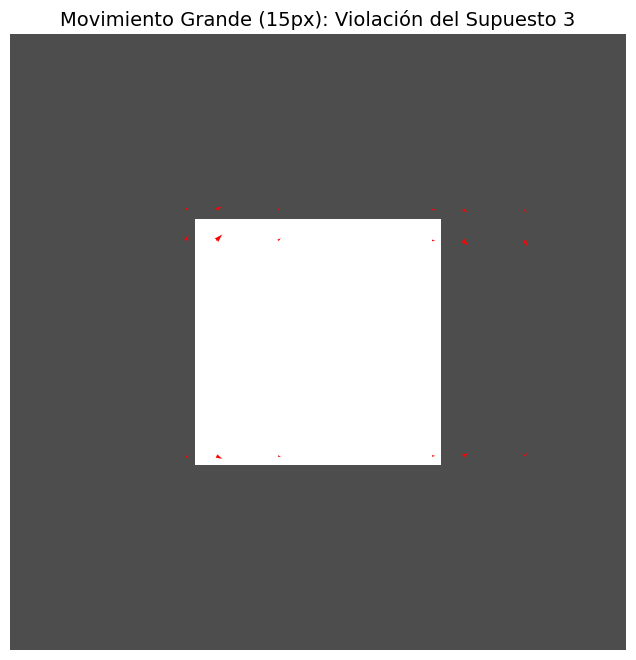

Flujo real: u=15, v=0
Flujo estimado: u=0.302, v=0.009

 Error significativo: 14.7 píxeles
Respuesta: La aproximación lineal de Taylor no es válida para desplazamientos grandes.


In [16]:
# Crear frames con desplazamiento grande (15 píxeles)
frame1_grande, frame2_grande = crear_frames_sinteticos(desplazamiento=15)

# Calcular gradientes
img_prom_grande = (frame1_grande + frame2_grande) / 2.0
Ix_grande, Iy_grande = calcular_gradiente_sobel(img_prom_grande)
It_grande = frame2_grande - frame1_grande

# Calcular flujo
x_g, y_g, u_g, v_g = calcular_flujo_grilla(Ix_grande, Iy_grande, It_grande, paso=5)

# Visualizar
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(frame1_grande, cmap='gray', alpha=0.7)
ax.quiver(x_g, y_g, u_g, v_g, 
          color='red', scale=50, width=0.003)
ax.set_title('Movimiento Grande (15px): Violación del Supuesto 3', fontsize=14)
ax.axis('off')
plt.show()

print(f"Flujo real: u=15, v=0")
print(f"Flujo estimado: u={np.mean(u_g):.3f}, v={np.mean(v_g):.3f}")
print(f"\n Error significativo: {abs(15 - np.mean(u_g)):.1f} píxeles")
print("Respuesta: La aproximación lineal de Taylor no es válida para desplazamientos grandes.")

### Experimento 2: Región Sin Textura

In [9]:
# Intentar calcular flujo en el centro del cuadrado (región uniforme)
x_centro, y_centro = 50, 50
u_centro, v_centro = lucas_kanade_ventana(Ix, Iy, It, x_centro, y_centro, tamaño_ventana=5)

print("En el centro del cuadrado (región uniforme blanca):")
print(f"  u = {u_centro:.3f}, v = {v_centro:.3f}")
print("\n¿Por qué obtenemos u=0 o valores pequeños?")
print("Respuesta: Sin gradientes espaciales (Ix ≈ 0, Iy ≈ 0), la matriz A^T A")
print("           es singular o mal condicionada → aperture problem.")

# Intentar en el borde (con textura)
x_borde, y_borde = 30, 50
u_borde, v_borde = lucas_kanade_ventana(Ix, Iy, It, x_borde, y_borde, tamaño_ventana=7)

print("\nEn el borde del cuadrado (transición blanco-negro):")
print(f"  u = {u_borde:.3f}, v = {v_borde:.3f}")
print("\n¡Mucho mejor! Los gradientes fuertes hacen la matriz A^T A bien condicionada.")

En el centro del cuadrado (región uniforme blanca):
  u = 0.000, v = 0.000

¿Por qué obtenemos u=0 o valores pequeños?
Respuesta: Sin gradientes espaciales (Ix ≈ 0, Iy ≈ 0), la matriz A^T A
           es singular o mal condicionada → aperture problem.

En el borde del cuadrado (transición blanco-negro):
  u = 0.000, v = 0.000

¡Mucho mejor! Los gradientes fuertes hacen la matriz A^T A bien condicionada.


---
## Paso 8: Visualización Avanzada - Magnitud y Dirección del Flujo

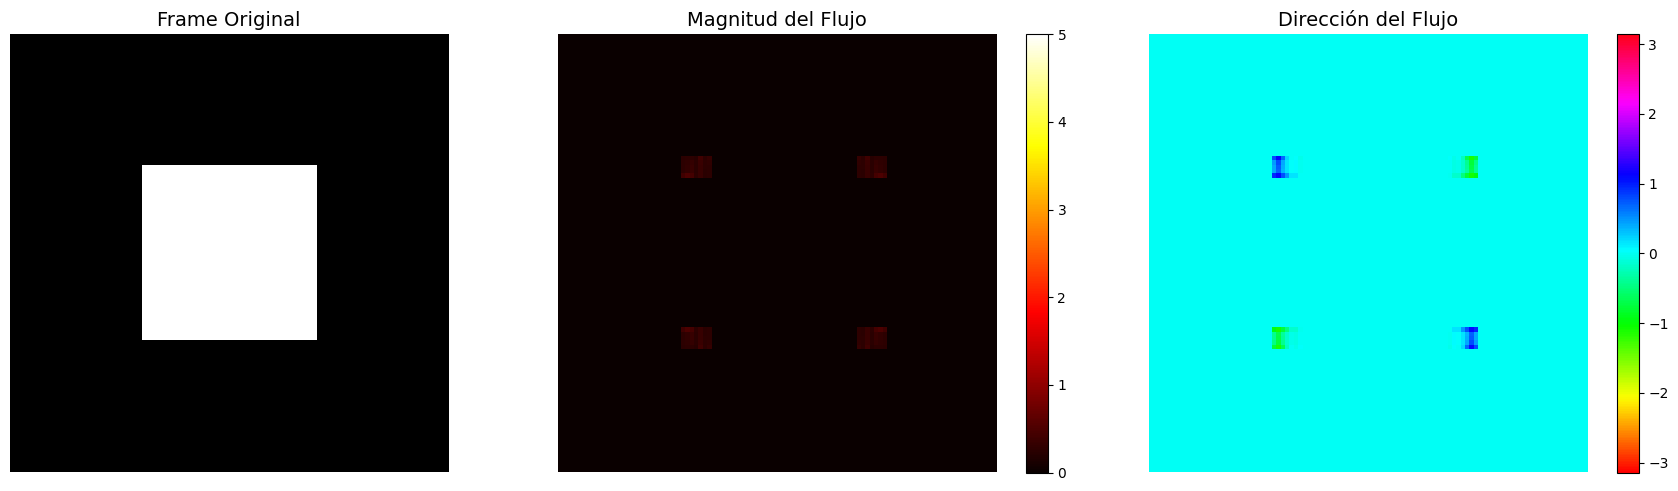

In [17]:
# Crear campo denso de flujo
flujo_denso = np.zeros((100, 100, 2), dtype=np.float32)

for y in range(3, 97):
    for x in range(3, 97):
        u, v = lucas_kanade_ventana(Ix, Iy, It, x, y, tamaño_ventana=5)
        flujo_denso[y, x, 0] = u
        flujo_denso[y, x, 1] = v

# Calcular magnitud y ángulo
magnitud = np.sqrt(flujo_denso[:, :, 0]**2 + flujo_denso[:, :, 1]**2)
angulo = np.arctan2(flujo_denso[:, :, 1], flujo_denso[:, :, 0])

# Visualizar
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Frame original
axes[0].imshow(frame1, cmap='gray')
axes[0].set_title('Frame Original', fontsize=14)
axes[0].axis('off')

# Magnitud del flujo
im1 = axes[1].imshow(magnitud, cmap='hot', vmin=0, vmax=5)
axes[1].set_title('Magnitud del Flujo', fontsize=14)
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1])

# Dirección del flujo
im2 = axes[2].imshow(angulo, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[2].set_title('Dirección del Flujo', fontsize=14)
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()


---
## Bonus: Función Completa para Uso General

In [18]:
def lucas_kanade_completo(frame1, frame2, puntos=None, tamaño_ventana=15):
    """
    Implementación completa de Lucas-Kanade.
    
    Args:
        frame1, frame2: Frames consecutivos (escala de grises, float32)
        puntos: Puntos donde calcular flujo. Si None, usa grilla.
        tamaño_ventana: Tamaño de ventana para Lucas-Kanade
    
    Returns:
        puntos, flujo: Coordenadas y vectores de flujo (u, v)
    """
    # Calcular gradientes
    img_prom = (frame1 + frame2) / 2.0
    Ix, Iy = calcular_gradiente_sobel(img_prom)
    It = frame2 - frame1
    
    # Si no se especifican puntos, usar grilla
    if puntos is None:
        x_pts, y_pts, u_vals, v_vals = calcular_flujo_grilla(
            Ix, Iy, It, paso=10, tamaño_ventana=tamaño_ventana
        )
        puntos = np.column_stack([x_pts, y_pts])
        flujo = np.column_stack([u_vals, v_vals])
    else:
        # Calcular flujo en puntos especificados
        flujo = []
        for x, y in puntos:
            u, v = lucas_kanade_ventana(Ix, Iy, It, int(x), int(y), tamaño_ventana)
            flujo.append([u, v])
        flujo = np.array(flujo)
    
    return puntos, flujo

print("Función lista para usar con video propio.")
print("\nEjemplo de uso:")
print("  puntos, flujo = lucas_kanade_completo(frame1, frame2)")

Función lista para usar con video propio.

Ejemplo de uso:
  puntos, flujo = lucas_kanade_completo(frame1, frame2)
